In [54]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import pathlib


import tensorflow as tf
from tensorflow.keras import layers,models
from keras import datasets
from keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import UpSampling2D, Dense, Flatten, BatchNormalization, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

(train_x, train_y), (test_x, test_y) = datasets.cifar10.load_data() #ucitavanje
print(train_x.shape, test_x.shape)


(50000, 32, 32, 3) (10000, 32, 32, 3)


# Show dataset

In [55]:
train_x = train_x[:40000]
train_y = train_y[:40000]
test_x = test_x[:10000]
test_y = test_y[:10000]
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_of_classes = 10


unique, counts = np.unique(train_y,return_counts=True)
print("Distribucija klasa u train setu:", dict(zip(unique, counts)))

unique, counts = np.unique(test_y, return_counts=True)
print("Distribucija klasa u  test setu:", dict(zip(unique, counts)))

print(train_x.shape)
print(test_x.shape)

Distribucija klasa u train setu: {0: 3986, 1: 3986, 2: 4048, 3: 3984, 4: 4003, 5: 3975, 6: 4020, 7: 4023, 8: 3997, 9: 3978}
Distribucija klasa u  test setu: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
(40000, 32, 32, 3)
(10000, 32, 32, 3)


# **Shows images from train dataset**
10 image for 10 classes

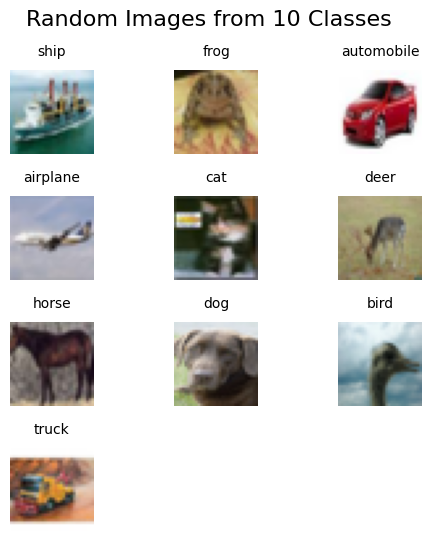

In [56]:
def show_random_images():
    plt.figure(figsize=(6, 6))
    indices = []
    for i in range(10):
        class_indices = np.where(train_y == i)[0]
        indices.append(np.random.choice(class_indices))

    np.random.shuffle(indices)

    for i, index in enumerate(indices):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(train_x[index])
        ax.set_title(classes[train_y[index][0]], pad=10, fontsize=10)  # Dodavanje razmaka između slike i teksta
        plt.axis('off') #skrivanje osa
    plt.subplots_adjust(wspace=0.2, hspace=0.5)  # Dodavanje paddinga između slika
    plt.suptitle('Random Images from 10 Classes', fontsize=16)
    plt.show()

# Prikaz 10 nasumičnih slika iz train_set-a
show_random_images()

# Shows image before preprocessing

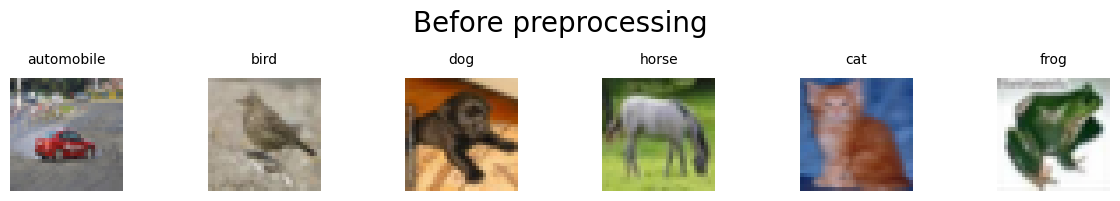

In [57]:

#mogao bih random
indices = [75, 120, 56, 87, 91 ,1023]
name_titles = [classes[train_y[i][0]] for i in indices]  # Kreiranje niza naslova, zbog one hot encoding-a


fig, axes = plt.subplots(1, len(indices), figsize=(len(indices) * 2, 2))  # Kreiranje figure sa 1 redom
fig.suptitle('Before preprocessing', fontsize=20)
for i, ax in enumerate(axes):
    ax.imshow(train_x[indices[i]])
    ax.set_title(name_titles[i], pad=10, fontsize=10)  # Dodavanje naslova iz niza
    ax.axis('off')  # Skrivanje osa

plt.tight_layout()
plt.show()

# Preprocessing datasets(train sets and test sets)

Predprocesiranje Horizontal flip, Random crop, dodao sam noramlizaciju i one hot encoding na labele(train_y, test_y)


In [58]:

import tensorflow.keras.layers as tfl
import random
from tensorflow.keras.layers import RandomCrop, RandomFlip
#keras preprocessing layers...
#height and width image
def processing_data(img_sizeH, img_sizeW):
  randomH = random.randint(8,10) # moze se uzeti i veca mera (6, 10 ) ali da ne skrati previse to se bojim.
  randomW = random.randint(8,10)

  modify = tf.keras.Sequential([
      tfl.Lambda(lambda x: tf.image.flip_left_right(x)),#ovo je za svaku sliku  #tfl.RandomFlip("horizontal") ovo je nasumicno
      tfl.RandomCrop(
          (int)(img_sizeH - img_sizeH/randomH),
          (int)(img_sizeW - img_sizeW/randomW),
          seed = 1
      ),
      tfl.Resizing(img_sizeH,img_sizeW) #cropujemo pa vracamo da sve budu 32x32
  ])
  return modify

#kupim
modify_train = processing_data(train_x.shape[1],train_x.shape[2])

#izmena
train_x = modify_train(train_x)
#normalizacija
train_x = train_x / 255
test_x = test_x / 255
#one hot
train_y = tf.keras.utils.to_categorical(train_y, 10)
test_y = tf.keras.utils.to_categorical(test_y, 10)

# Shows image after preprocessing

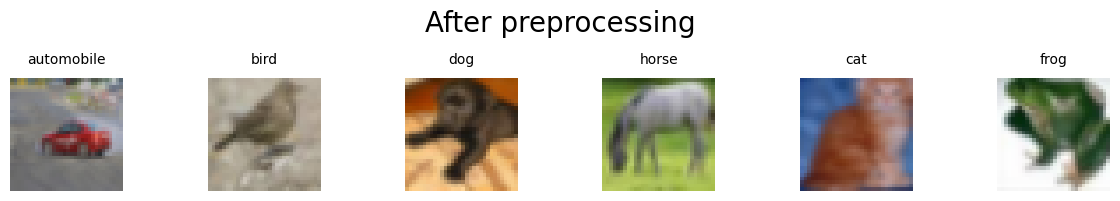

In [59]:
fig, axes = plt.subplots(1, len(indices), figsize=(len(indices) * 2, 2))  # Kreiranje figure sa 1
fig.suptitle('After preprocessing', fontsize = 20)
for i, ax in enumerate(axes):
    ax.imshow(train_x[indices[i]])
    ax.set_title(name_titles[i], pad=10, fontsize=10)  # Dodavanje naslova
    ax.axis('off')  # Skrivanje osa

plt.tight_layout()
plt.show()

# **Loading ResNet50 model and add some layers**


In [23]:
num_of_classes = 10
def classifier(conv_base_output):
    x = layers.Flatten()(conv_base_output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(num_of_classes, activation='softmax')(x)
    return output
def loadResNet50(inputs):
    conv_base = ResNet50(include_top=False, weights='imagenet',input_shape = (224,224,3))(inputs) 
    return conv_base
def final_model_outputs(inputs):
    resize_inputs = tfl.UpSampling2D(size=(7, 7))(inputs) 
    conv_base = loadResNet50(resize_inputs)
    classification_output = classifier(conv_base)
    return classification_output
def load_model(modelH, modelW):
    inputs = tfl.Input(shape=(modelH, modelW, 3))
    classification_output = final_model_outputs(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)
    return model

#load model
model = load_model(train_x.shape[1], train_x.shape[2])
#show model
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100352)         │       401,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,844,234 (140.55 MB)

 Trainable params: 36,589,898 (139.58 MB)

 Non-trainable params: 254,336 (993.50 KB)

In [15]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=32,callbacks=[early_stopping])

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 248s 159ms/step - accuracy: 0.3640 - loss: 1.8445 - val_accuracy: 0.5406 - val_loss: 1.3072
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 194s 155ms/step - accuracy: 0.6526 - loss: 1.0358 - val_accuracy: 0.5114 - val_loss: 1.6263
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 194s 155ms/step - accuracy: 0.7095 - loss: 0.8689 - val_accuracy: 0.5788 - val_loss: 1.2932
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 194s 155ms/step - accuracy: 0.7494 - loss: 0.7504 - val_accuracy: 0.6855 - val_loss: 0.9617
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 194s 155ms/step - accuracy: 0.7855 - loss: 0.6520 - val_accuracy: 0.6423 - val_loss: 1.1290
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 194s 155ms/step - accuracy: 0.8148 - loss: 0.5744 - val_accuracy: 0.7546 - val_loss: 0.7332
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 194s 155ms/step - accuracy: 0.8386 - loss: 0.4951 - val_accuracy: 0.6813 - val_loss: 1.0147
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 194s 155ms/step - ac

# Acc and loss in graph

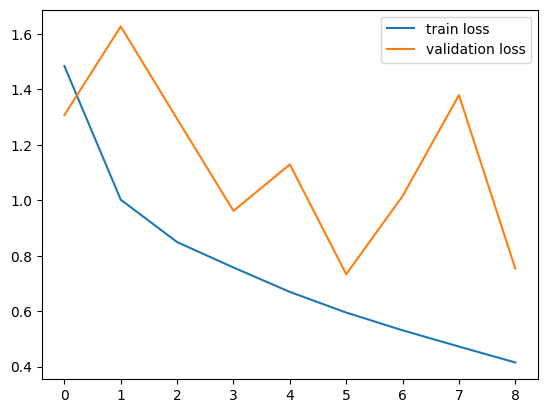

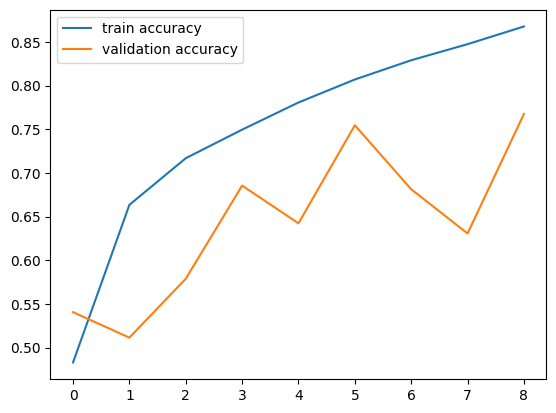

In [16]:
h = history
#plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

#plot the accuracy value
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

Trening gubitak: Stalno opada, što je očekivano ponašanje tokom treninga. Model sve bolje uči na trening skupu.
Validacioni gubitak: Takođe opada u početnim epohama, ali nakon određene tačke počinje rasti. Ovo je indikator overfitting-a. Model se previše specijalizirao za trening skup i lošije generalizira na nepoznate podatke.

Trening tačnost: Stalno raste, što je u skladu s opadanjem trening gubitka. Model sve tačnije klasificira primere iz trening skupa.
Validaciona tačnost: Dosta ide gore dole rezultati se od prve pa do zadnje 9 epohe su u slinom range-u. Ovo potvrđuje zaključak o prenaučenosti(overfitting-u).


**Moja sledeći potez je da povećam batch size na 64 da vidim kako model reaguje da bi bolje se ažurirare težine u slojevima**
**Mislim i da smanjim stopu učenja da ne bi došlo do pretreniranosti modela jer vidim da se dobro ponaša na training set-u**
**Staviću broj epoha na 10**

In [25]:
from tensorflow.keras.metrics import Precision, Recall
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history2 = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=64,callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1726314669.137130     111 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 245s 288ms/step - accuracy: 0.4923 - loss: 1.5767 - precision: 0.6770 - recall: 0.3042 - val_accuracy: 0.2236 - val_loss: 2.4173 - val_precision: 0.2958 - val_recall: 0.1081
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 175s 279ms/step - accuracy: 0.8621 - loss: 0.5409 - precision: 0.9276 - recall: 0.7620 - val_accuracy: 0.8634 - val_loss: 0.4423 - val_precision: 0.9060 - val_recall: 0.8234
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 174s 279ms/step - accuracy: 0.9252 - loss: 0.3196 - precision: 0.9561 - recall: 0.8800 - val_accuracy: 0.8878 - val_loss: 0.3636 - val_precision: 0.9179 - val_recall: 0.8601
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 174s 279ms/step - accuracy: 0.9495 - loss: 0.2213 - precision: 0.9671 - recall: 0.9235 - val_accuracy: 0.8633 - val_loss: 0.4420 - val_precision: 0.8965 - val_recall: 0.8389
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 174s 279ms/step - accuracy: 0.9600 - loss: 0.1751 - precision: 0.9724 - recall: 0.9431 - val_accuracy: 0.8403 - val

early stopping nakon 6 epoha overfitting(pretreniranost), model je dostogao val_acc od 88% i nije nastavio da se poboljsava, bio je tu oko 87% i 86% mozda bi nastavi da raste.
val los najmanji je bio 0.3913 od tada se nije spustao.
Model je uspeo da nauči predstavljanje podataka i postiže dobre rezultate na validacionom skupu.
Mehanizam rane zaustavljanja je sprečio prekomerno obučavanje modela.

Recall = True Positives / (True Positives + False Negatives) - visok recall bolji model
Precision = True Positives / (True Positives + False Positives) - visok bolji model

NAJBOLJE SE OVAJ MODEL POKAZAO.


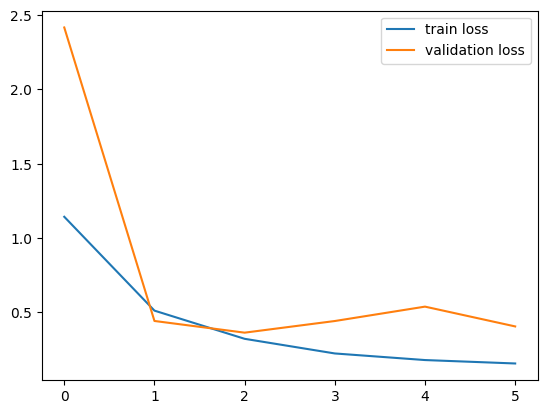

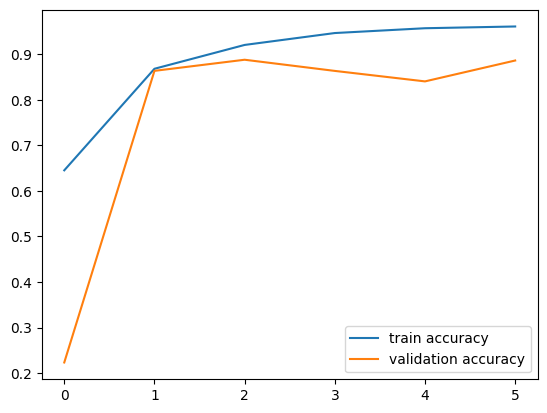

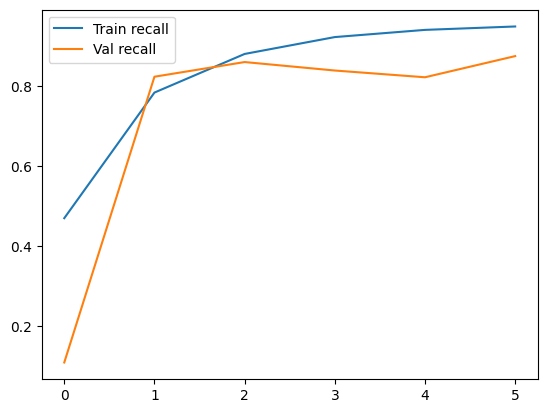

In [27]:
h = history2
#plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

#plot the accuracy value
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()


plt.plot(h.history['recall'], label='Train recall')
plt.plot(h.history['val_recall'], label='Val recall')
plt.legend()
plt.show()




**Na osnovu prikazanih grafikona, model izgleda dobro. Gubitak se smanjuje, a tačnost se povećava tokom obuke, što ukazuje da je model uspešno obučen i da se dobro generalizuje na nove podatke.**

Prednosti:

Preciznost i osetljivost: Postignute su visoke vrednosti za precision i recall, što znači da model ne samo da tačno klasifikuje pozitivne primere, već i uspešno hvata većinu relevantnih instanci.
Validaciona tačnost: Validaciona tačnost raste stabilno, uz solidnu validacionu preciznost i recall, što sugeriše bolju generalizaciju modela na neviđenim podacima.
Slabosti:

Početna epoha: U prvoj epohi, model ima nisku preciznost i osetljivost, što je normalno, ali kako epohe napreduju, performanse značajno rastu.
Overfitting se ne primećuje odmah, ali postoji potencijal da se pojavi nakon 10 epoha, što može biti rešeno pažljivim podešavanjem early stopping mehanizma.
Zaključak: Model je znatno bolji, posebno zbog uvedenih metrika (precision, recall), i pokazuje se kao stabilan i efikasan za klasifikaciju.

In [28]:
model.evaluate(test_x, test_y)

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.8924 - loss: 0.3884 - precision: 0.9056 - recall: 0.8808


[0.4055803716182709, 0.8860999941825867, 0.899835467338562, 0.875]

In [29]:
model.evaluate(train_x, train_y)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.9744 - loss: 0.0873 - precision: 0.9790 - recall: 0.9701


[0.08812081813812256,
 0.9741500020027161,
 0.9786375164985657,
 0.9700499773025513]

Na osnovu ovoga mozemo videti da je model solidan i da sto se tice ucenja da je dosao do limita sa 97% tacnosti, dok je na validacionom skupu dosao do 89%, na osnovu ovoga mogu da zakljucim da je pretreniram model i da jedina solucija koja ostaje da probam da model odnosno deo **resnet50** zamrznem.
ResNet-50 kao bazni model sa unapred treniranim težinama, zamrzavanje slojeva pomaže da se unapred naučene osobine sačuvaju, što smanjuje rizik od prekomernog učenja.

In [72]:
num_of_classes = 10
from tensorflow.keras import regularizers
def classifier(conv_base_output):
    x = layers.BatchNormalization()(conv_base_output)  # Apply before Flatten
    x = layers.Flatten()(x)  # Flatten output from ResNet50
    x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)  # Use BatchNormalization after Dense
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)  # Again after second Dense
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_of_classes, activation='softmax')(x)  # Output layer
    return output

def loadResNet50(inputs):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    for layer in base_model.layers[:30]:
        layer.trainable = False
    base_output = base_model(inputs)
    return base_output

def final_model_outputs(inputs):
    resize_inputs = tfl.Resizing(224, 224)(inputs)  # Correctly resize inputs to 224x224
    conv_base = loadResNet50(resize_inputs)
    classification_output = classifier(conv_base)
    return classification_output

def load_model(modelH, modelW):
    inputs = tfl.Input(shape=(modelH, modelW, 3))
    classification_output = final_model_outputs(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)
    return model

#load model
newModel = load_model(train_x.shape[1], train_x.shape[2])
#show model
newModel.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_16 (Resizing)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,450,762 (139.05 MB)

 Trainable params: 36,220,682 (138.17 MB)

 Non-trainable params: 230,080 (898.75 KB)

In [61]:
newModel.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history3 = newModel.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=128,callbacks=[early_stopping])

Epoch 1/10


2024-09-14 13:42:23.151516: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,256,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,512,28,28]{3,2,1,0}, f32[512,256,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-14 13:42:23.857930: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.706516307s
Trying algorithm eng0{} for conv (f32[128,256,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,512,28,28]{3,2,1,0}, f32[512,256,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_con

312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.4023 - loss: 4.3990

I0000 00:00:1726321500.357598     109 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 16 bytes spill stores, 16 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 210s 507ms/step - accuracy: 0.4031 - loss: 4.3943 - val_accuracy: 0.3975 - val_loss: 3.5638
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 431ms/step - accuracy: 0.7440 - loss: 2.3476 - val_accuracy: 0.7798 - val_loss: 1.7392
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 431ms/step - accuracy: 0.8485 - loss: 1.4371 - val_accuracy: 0.8247 - val_loss: 1.2079
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 431ms/step - accuracy: 0.9039 - loss: 0.9235 - val_accuracy: 0.7732 - val_loss: 1.1671
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 431ms/step - accuracy: 0.9325 - loss: 0.6382 - val_accuracy: 0.8378 - val_loss: 0.8389
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 431ms/step - accuracy: 0.9469 - loss: 0.4649 - val_accuracy: 0.8461 - val_loss: 0.7577
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 432ms/step - accuracy: 0.9615 - loss: 0.3486 - val_accuracy: 0.7856 - val_loss: 0.9710
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 431ms/step - accuracy: 0.9676 - loss: 0.28

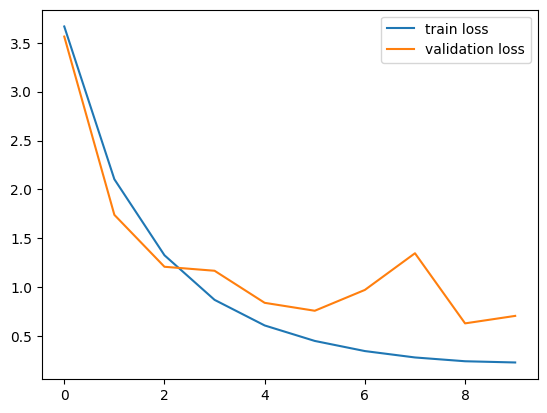

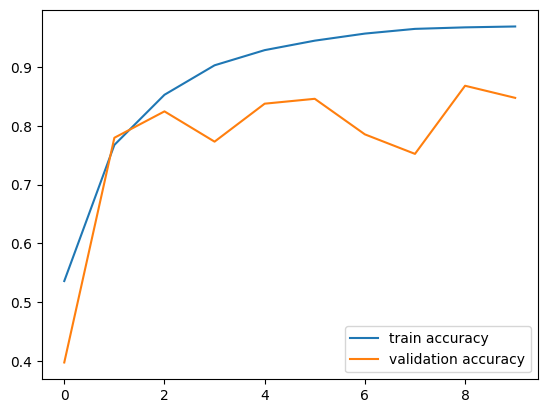

In [62]:
h = history3
#plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

#plot the accuracy value
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()


In [64]:
newModel.evaluate(test_x, test_y)

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8577 - loss: 0.6679


[0.7051325440406799, 0.8476999998092651]

Kao sto vidimo nakon fine tuning-a odnosno zamrzavanja 30 slojeva u ResNet50 nismo imali neka poboljsanja, gde sam dodao i kernel_regularizer=regularizers.l2(0.01) u Dense i stavio lr = 0.0001 i batch size = 128
Model se pokazuje dobrim, postigao je visoku tačnost i stabilno smanjivao grešku tokom treninga. Međutim, nakon nekoliko epoha, dolazi do prenaučavanja (overfittinga), gde tačnost na trening podacima nastavlja da raste, dok se validaciona tačnost smanjuje i greške na validaciji rastu.

In [73]:
newModel.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history4 = newModel.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=15, batch_size=64,callbacks=[early_stopping])

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 242ms/step - accuracy: 0.3614 - loss: 4.4715 - val_accuracy: 0.7395 - val_loss: 2.2696
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.7519 - loss: 2.0556 - val_accuracy: 0.7964 - val_loss: 1.3860
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.8531 - loss: 1.1485 - val_accuracy: 0.8262 - val_loss: 0.9856
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.8965 - loss: 0.7350 - val_accuracy: 0.8289 - val_loss: 0.8108
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.9211 - loss: 0.5297 - val_accuracy: 0.8557 - val_loss: 0.6962
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.9339 - loss: 0.4334 - val_accuracy: 0.8601 - val_loss: 0.6468
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.9460 - loss: 0.3606 - val_accuracy: 0.7992 - val_loss: 0.9245
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.9523 -

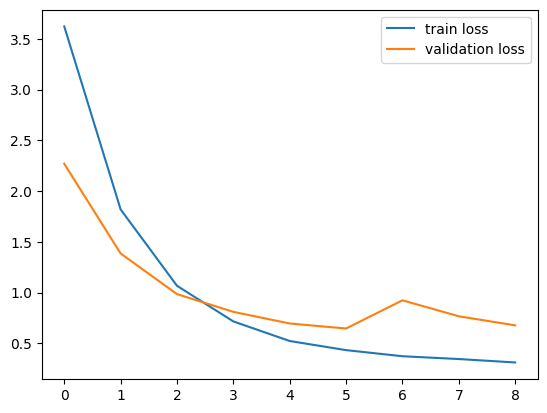

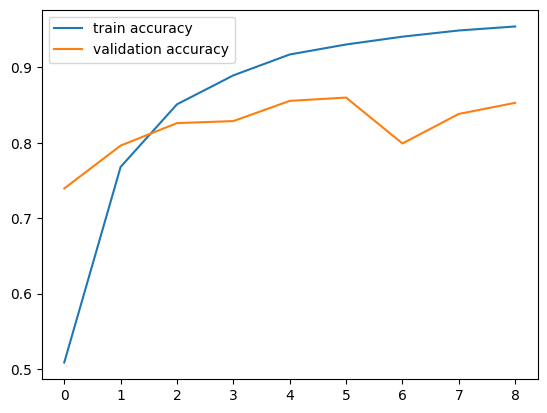

In [74]:
h = history4
#plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

#plot the accuracy value
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()


Opšta analiza:
Dobar znak: Model je pokazao dosledna poboljšanja u tačnosti i smanjenju gubitka, naročito u početnim epohama.
Moguća pretreniranost: U poslednjim epohama model pokazuje znakove da može biti pretreniran, jer postoji razlika između trening tačnosti (preko 95%) i validacione tačnosti (85.31% u poslednjoj epohi). To ukazuje na rizik da model nauči previše specifičnih obrazaca iz trening seta, što smanjuje njegovu sposobnost generalizacije.